The derivative of a Gaussian Process is still a Gaussian Process and what we need to compute mean and variance is just the derivative of the kernel function. In this notebook we are going to consider the kernel to be the RBF kernel, since it is easy to differentiate. We are going to make the analyical derivatives of the kernel. This is for educational purposes. 
You can give a look at chapter 9 of 
``` Williams, C.K. and Rasmussen, C.E., 2006. Gaussian processes for machine learning (Vol. 2, No. 3, p. 4). Cambridge, MA: MIT press. ``` The book will help you understand how I am computing the mean and variance by simply using the derivative of the kernel function when making prediction on a new input. 
**This is an advanced topic**. If you feel lost or feel that there is a mistake, please contact the author (Giovanni Franzese) at g.franzese@tudelft.nl.

Here is a small recap of what we are going to compute: 
We first fit the posterior distribution p(f|y) using Bayes theorem $p(f|y)=p(y|f)p(f)$ where we have the hypothesis that the likelihood is Gaussian and also the prior is a Gaussian Process. 

We can make predictions on new points, where we can predict $p(f^*|f,y)$, or we can also predict $p(y^*|f,y)$ by simply using the estimated likelihood noise. 
When we compute the derivatives, we only care about the probability distribution of the latent function, i.e., $ p(f' ^*| f,y) $and $p(f''^*| f,y)$. The fact that there was a noisy input will still affect the prediction of mean and variance, given that the prediction $p(f|y)$ takes the noise into account in the diagonal of the covariance matrix. 

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sympy import symbols, diff, exp, simplify

# Define symbols
x, x_prime, Sigma_v, sigma_l = symbols('x x_prime Sigma_v sigma_l')

# Define the function k_RBF(x, x_prime)
k_RBF = Sigma_v * exp(-(x - x_prime)**2/(2* (sigma_l)**2))


dk_dx_prime = simplify(diff(k_RBF, x_prime, 1))

# print("dk_dx_prime :", dk_dx_prime)

ratio_dk_dx_prime = simplify(dk_dx_prime/ k_RBF)

print("coefficient of dk_dx_prime that multiplies the kernel itself ", ratio_dk_dx_prime)

dk2_dx_dx_prime = diff(diff(k_RBF, x, 1), x_prime, 1)


dk2_dx_dx_prime= simplify(dk2_dx_dx_prime.subs(x, x_prime))


print("dk2_dx_dx_prime :",dk2_dx_dx_prime)

dk2_dx_prime = simplify(diff(k_RBF, x_prime, 2))

# print("dk2_dx_prime :", dk2_dx_prime)

print("coefficient of dk2_dx_prime that multiplies the kernel itself ", simplify(dk2_dx_prime/ k_RBF))

dk4_dx2_dx_prime2 = diff(diff(k_RBF, x, 2), x_prime, 2)


dk4_dx2_dx_prime2=simplify(dk4_dx2_dx_prime2.subs(x, x_prime))

print("dk4_dx2_dx_prime2 :", dk4_dx2_dx_prime2)

coefficient of dk_dx_prime that multiplies the kernel itself  (x - x_prime)/sigma_l**2
dk2_dx_dx_prime : Sigma_v/sigma_l**2
coefficient of dk2_dx_prime that multiplies the kernel itself  (-sigma_l**2 + (x - x_prime)**2)/sigma_l**4
dk4_dx2_dx_prime2 : 3*Sigma_v/sigma_l**4


In [3]:
class GPR():
    def __init__(self, kernel, alpha=1e-10, n_restarts_optimizer=20):
        self.gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=n_restarts_optimizer)

    def fit(self, X, Y):
        self.X=X
        self.Y=Y
        self.n_features=np.shape(self.X)[1]
        self.n_samples=np.shape(self.X)[0]
        self.n_outputs=np.shape(self.Y)[1]
        gp_ = self.gp.fit(self.X, self.Y)

        self.kernel_ = gp_.kernel_

        self.length_scales=self.kernel_.get_params()['k1__k2__length_scale'].reshape(1,-1)
        
        print("Lengthscale", self.length_scales)
        
        self.noise_var_ = gp_.alpha + self.kernel_.get_params()['k2__noise_level']

        print("Noise variance", self.noise_var_)

        self.Sigma_v   = self.kernel_.get_params()['k1__k1__constant_value'].reshape(1,-1)

        K_ = self.kernel_(self.X, self.X) + (self.noise_var_ * np.eye(len(self.X)))
        
        self.K_inv = np.linalg.inv(K_)

    def predict(self, x, return_std=False, return_covar=False): # here we predict p(y*|f,y) 
        k_star = self.kernel_(self.X, x)
        k_star_K_inv_ = np.transpose(k_star) @ self.K_inv
        self.mu=k_star_K_inv_ @ self.Y
        if return_covar==True:
            self.var = self.kernel_(x, x)+ self.noise_var_ -  k_star_K_inv_ @ k_star
            
            return self.mu, self.var
        if return_std==True:
            self.sigma = self.kernel_(x, x)+ self.noise_var_ -  k_star_K_inv_ @ k_star
            self.std= np.sqrt(np.diag(self.sigma) )   
            return self.mu, self.std
        return self.mu
    
    def predict_first_derivative(self, x, return_std=False, return_covar=False): # here we predict p(f'*| f, y). 
        """Input has shape n_query x n_features. 
        There are two outputs,
        1. mean of the derivative function 
        2. predicted standar deviation of the first derivative
        Each output has shape  n_outputs x n_query x n_features.
        The output in position i,j,k has the derivative respect to the k-th feature of the i-th output, in position of the j-th data point.
        For the derivative of sigma n_outputs is equal to 1
        When computing the covariance matrix the output has shape  n_outputs x n_query x n_query x n_features.
        """
        lscale=self.length_scales
        alfa=  self.K_inv @ self.Y 
        k_star= self.kernel_(x, self.X)
        X_T= (self.X).transpose()
        x_T = x.transpose()
        lscale_T= lscale.transpose()
        X_reshaped = X_T[:,  np.newaxis,:]
        x_reshaped = x_T[:,  :, np.newaxis]
        lascale_rehaped= lscale_T[:,  :, np.newaxis]

        # Calculate the difference
        difference_matrix =  X_reshaped - x_reshaped
        
        coefficient= difference_matrix/ ( lascale_rehaped** 2) 

        #coefficient of dk_dx_prime that multiplies the kernel itself  (x - x_prime)/sigma_l**2
        dk_star_dx=  coefficient * k_star
        df_dx = dk_star_dx @ alfa 
        df_dx=df_dx.transpose(2,1,0)
        if return_covar==True:
            #dk2_dx_dx_prime : Sigma_v/sigma_l**2
            dk_star_dx_K_inv_= dk_star_dx @  self.K_inv
            var_der=self.Sigma_v/(lascale_rehaped**2) - dk_star_dx_K_inv_ @ dk_star_dx.transpose(0,2,1)
            var_der= var_der[np.newaxis, :, :, :]
            var_der= var_der.transpose(0,2,3,1)
            return df_dx, var_der
        if return_std==True:
            #dk2_dx_dx_prime : Sigma_v/sigma_l**2
            dk_star_dx_K_inv_= dk_star_dx @  self.K_inv
            diag_k_K_inv_k = np.sum(dk_star_dx_K_inv_ * dk_star_dx, axis=2)
            var_diag= self.Sigma_v/(lascale_rehaped**2) - diag_k_K_inv_k
            sigma_df_dx=np.sqrt(var_diag)
            sigma_df_dx= sigma_df_dx.transpose(0,2,1)
            return df_dx, sigma_df_dx
        return df_dx
     
    def predict_second_derivative(self, x, return_std=False, return_covar=False): # here we predict p(f''*| f, y).
        """Input has shape n_query x n_features. 
        There are two outputs,
        1. mean of the second derivative function 
        2. predicted standar deviation of the second derivative
        Each output has shape  n_outputs x n_query x n_features.
        The output in position i,j,k has the derivative respect to the k-th feature of the i-th output, in position of the j-th data point.
        When computing the covariance matrix the output has shape  n_outputs x n_query x n_query x n_features. 
        """
        lscale=self.length_scales
        alfa=  self.K_inv @ self.Y 
        k_star= self.kernel_(x, self.X)
        X_T= (self.X).transpose()
        x_T = x.transpose()
        lscale_T= lscale.transpose()
        X_reshaped = X_T[:,  np.newaxis,:]
        x_reshaped = x_T[:,  :, np.newaxis]
        lascale_rehaped= lscale_T[:,  :, np.newaxis]

        # Calculate the difference
        difference_matrix =  X_reshaped - x_reshaped
        #coefficient of dk2_dx_prime that multiplies the kernel itself  [-sigma_l**2 + (x - x_prime)**2]/sigma_l**4

        coefficient= (difference_matrix**2 - lascale_rehaped** 2 ) / ( lascale_rehaped** 4) 

        dk_star_dx=  coefficient * k_star
        df_dx = dk_star_dx @ alfa 
        df_dx=df_dx.transpose(2,1,0)
        if return_covar==True:
            dk_star_dx_K_inv_= dk_star_dx @  self.K_inv
            #dk4_dx2_dx_prime2 : 3*Sigma_v/sigma_l**4
        
            var_der=3*self.Sigma_v/(lascale_rehaped**4) - dk_star_dx_K_inv_ @ dk_star_dx.transpose(0,2,1)
            var_der= var_der[np.newaxis, :, :, :]
            var_der= var_der.transpose(0,2,3,1)
            return df_dx, var_der
        if return_std==True:

            #dk4_dx2_dx_prime2 : 3*Sigma_v/sigma_l**4
            dk_star_dx_K_inv_= dk_star_dx @  self.K_inv
            diag_k_K_inv_k = np.sum(dk_star_dx_K_inv_ * dk_star_dx, axis=2) 
            var_diag= 3*self.Sigma_v/(lascale_rehaped**4) - diag_k_K_inv_k
            sigma_df_dx=np.sqrt(var_diag)
            sigma_df_dx= sigma_df_dx.transpose(0,2,1)
            return df_dx, sigma_df_dx
        
        return df_dx


In [4]:
amplitude=1
frequency=0.1
noise=0.1
number_of_cycles=4
omega= 2*np.pi*frequency
number_samples=500
time=np.linspace(0, number_of_cycles/frequency,number_samples)

y=amplitude * np.sin(omega*time) 
y_noise= y+ np.random.normal(0, noise, number_samples)
dx_analytical= amplitude * omega* np.cos(omega*time)
dx2_analytical= - amplitude * omega**2 * np.sin(omega*time)
# prepare inputs for gp
X=time.reshape(-1,1)
Y=y_noise.reshape(-1,1)
k = C(constant_value=1)  * RBF(1*np.ones(1)) + WhiteKernel(0.01 )
gp=GPR(kernel=k)
gp.fit(X,Y)

Lengthscale [[4.16899385]]
Noise variance 0.009448774844892937


In [5]:
t_test=np.linspace(0, number_of_cycles/frequency, int(number_samples)).reshape(-1,1)
y_pred, std =gp.predict(t_test, return_std=True)
f_prime, std_prime=gp.predict_first_derivative(t_test, return_std=True)
f_second, std_second=gp.predict_second_derivative(t_test, return_std=True)

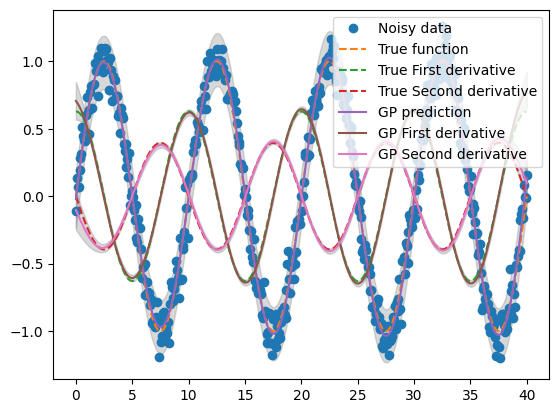

In [6]:
# plt.plot(t_test, y_pred)
plt.plot(t_test,  y_noise, 'o', label='Noisy data')
plt.plot(t_test, y, '--', label='True function')
plt.plot(t_test, dx_analytical, '--', label='True First derivative')
plt.plot(t_test, dx2_analytical, '--', label='True Second derivative')
plt.plot(t_test, y_pred, label='GP prediction')
plt.plot(t_test, f_prime[0,:,0], label='GP First derivative')
plt.plot(t_test, f_second[0,:, 0], label='GP Second derivative')

plt.fill_between(t_test.reshape(-1,), y_pred[:,0]-2*std.reshape(-1,), y_pred[:,0]+2* std.reshape(-1,), color='gray', alpha=0.3)
plt.fill_between(t_test.reshape(-1,), f_prime[0,:,0]-2*std_prime.reshape(-1,), f_prime[0,:,0]+2* std_prime.reshape(-1,), color='gray', alpha=0.3)
plt.fill_between(t_test.reshape(-1,), f_second[0,:,0]-2* std_second.reshape(-1,), f_second[0,:,0]+2* std_second.reshape(-1,), color='gray', alpha=0.3)

plt.legend()

### Compare the performance of the savgol Filter

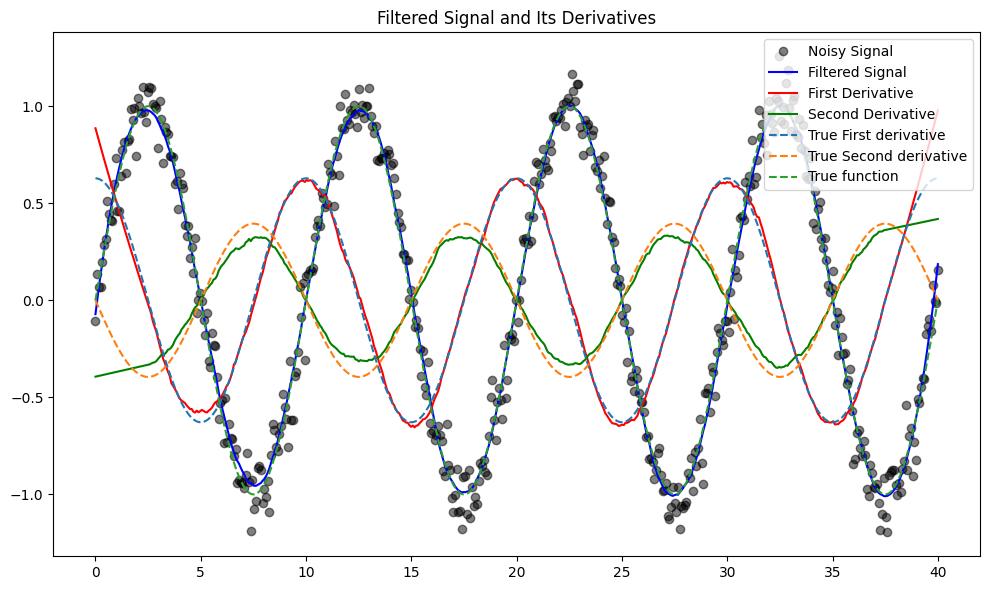

In [7]:
from scipy.signal import savgol_filter
from scipy.misc import derivative
import numpy as np

# Example data
X=time.reshape(-1,)
Y=y_noise.reshape(-1,)
window_length = 65    # Window length for Savitzky-Golay filter
polyorder = 3        # Polynomial order for Savitzky-Golay filter

# Apply Savitzky-Golay filter
filtered_signal = savgol_filter(Y, window_length, polyorder)


first_derivative=savgol_filter(Y, window_length, polyorder, deriv=1, delta=X[1]-X[0])

second_derivative= savgol_filter(Y, window_length, polyorder, deriv=2, delta=X[1]-X[0])

# Plot
plt.figure(figsize=(10, 6))

plt.plot(X, Y,'o',  label='Noisy Signal', color='black', alpha=0.5)
plt.plot(X, filtered_signal, label='Filtered Signal', color='blue')
plt.title('Filtered Signal and Its Derivatives')

plt.plot(X, first_derivative, label='First Derivative', color='red')

plt.plot(X, second_derivative, label='Second Derivative', color='green')
plt.plot(t_test, dx_analytical, '--', label='True First derivative')
plt.plot(t_test, dx2_analytical, '--', label='True Second derivative')
plt.plot(t_test, y, '--', label='True function')
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
# create fake dataset with 2 features
X=np.random.rand(100,2)
Y=np.random.rand(100,3)
gp=GPR(kernel=k)
gp.fit(X,Y)
y_pred, std =gp.predict(X, return_std=True)

f_prime, std_prime=gp.predict_first_derivative(X, return_std=True)
f_second, std_second=gp.predict_second_derivative(X, return_std=True)
f_prime, covar_prime=gp.predict_first_derivative(X, return_covar=True)
f_second, covar_second=gp.predict_second_derivative(X, return_covar=True)

Lengthscale [[100000.]]
Noise variance 0.08568681733188252


/home/oem/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


This version of the code  for the calculation of the derivatives of the Gaussian Process does not compute the full hessian of the prediction for the second order derivative of the latent function. If the jacobian of a multi output function is defined as: 
$$
J(f) = \begin{bmatrix}
\frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} & \cdots & \frac{\partial f_1}{\partial x_n} \\
\frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2} & \cdots & \frac{\partial f_2}{\partial x_n} \\
\vdots & \vdots & \ddots & \vdots \\

\frac{\partial f_m}{\partial x_1} & \frac{\partial f_m}{\partial x_2} & \cdots & \frac{\partial f_m}{\partial x_n} \\
\end{bmatrix}
$$
where $f$ is a vector of $m$ functions and $x$ is a vector of $n$ inputs, then the hessian of the function is defined as:

In [10]:
print("The input has shape ", X.shape[1])
print("The output has shape ", Y.shape[1])
print("The mean shape", y_pred.shape)
print("The standard deviation shape", std.shape)
print(" The First Derivative shape", f_prime.shape)
print("Standard derivation of the first derivative shape", std_prime.shape)
print("Covariance matrix of the first derviative shape", covar_prime.shape)

print(" The Second Derivative shape", f_second.shape)
print("Standard derivation of the first derivative shape", std_second.shape)
print("Covariance matrix of the first derviative shape", covar_second.shape)

The input has shape  2
The output has shape  3
The mean shape (100, 3)
The standard deviation shape (100,)
 The First Derivative shape (3, 100, 2)
Standard derivation of the first derivative shape (1, 100, 2)
Covariance matrix of the first derviative shape (1, 100, 100, 2)
 The Second Derivative shape (3, 100, 2)
Standard derivation of the first derivative shape (1, 100, 2)
Covariance matrix of the first derviative shape (1, 100, 100, 2)


In [11]:
import torch

# Define the kernel function k(x1, x2)
def kernel(x1, x2):
    # Example kernel function (Gaussian kernel)
    return torch.exp(-torch.norm(x1 - x2, dim=2)**2)

# Define the inputs x1 and x2
n = 20  # number of points in the first dimension
m = 40  # number of points in the second dimension
d = 2  # dimensionality of the points
x1 = torch.randn(n, d, requires_grad=True)
x2 = torch.randn(m, d)

# Expand dimensions for broadcasting
x1 = x1.unsqueeze(1)  # Shape: (n, 1, d)
x2 = x2.unsqueeze(0)  # Shape: (1, m, d)

# Evaluate the kernel function at x1 and x2
k_value = kernel(x1, x2)

# Compute the partial derivative of the kernel with respect to x1
grad_x1 = torch.autograd.functional.jacobian(lambda x1: torch.sum(kernel(x1, x2),0), x1)

print("Shape of Partial derivative of kernel w.r.t. x1:", grad_x1.shape)


hesssian_1 = torch.autograd.functional.jacobian(lambda x1: torch.sum(kernel(x1, x2),0), x1)

print("Shape of Second Partial derivative of kernel w.r.t. x1:", hesssian_1.shape)

Shape of Partial derivative of kernel w.r.t. x1: torch.Size([40, 20, 1, 2])
Shape of Second Partial derivative of kernel w.r.t. x1: torch.Size([40, 20, 1, 2])
